In [4]:
import numpy as np
from scipy.io import arff
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping

In [5]:
data, meta = arff.loadarff('dataSet.arff')
df = pd.DataFrame(data)
df = df.astype(int)
    
X = df.drop('Result', axis=1)
Y = df['Result']

label_encoder = LabelEncoder()
Y_integer = label_encoder.fit_transform(Y)

# Y_binary = (Y + 1) // 2
# print(Y_binary[0:5])
# print(Y.head())


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_integer, test_size = 0.2, random_state = 2023)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=X.shape[1]))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(30, input_shape=(X.shape[1],), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(12, activation=tf.nn.relu))

# model.add(tf.keras.layers.Dense(4, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, validation_split=0.2)

Epoch 1/100
222/222 [==============================] - 1s 2ms/step - loss: 0.3438 - accuracy: 0.8619 - val_loss: 0.1922 - val_accuracy: 0.9248
Epoch 2/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1789 - accuracy: 0.9288 - val_loss: 0.1640 - val_accuracy: 0.9282
Epoch 3/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1601 - accuracy: 0.9361 - val_loss: 0.1566 - val_accuracy: 0.9310
Epoch 4/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1487 - accuracy: 0.9426 - val_loss: 0.1454 - val_accuracy: 0.9378
Epoch 5/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1400 - accuracy: 0.9449 - val_loss: 0.1388 - val_accuracy: 0.9429
Epoch 6/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9477 - val_loss: 0.1321 - val_accuracy: 0.9474
Epoch 7/100
222/222 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.9495 - val_loss: 0.1295 - val_accuracy: 0.9469

In [7]:
accuracy = model.evaluate(X_test, Y_test)[1]

70/70 [==============================] - 0s 710us/step - loss: 0.1462 - accuracy: 0.9602


In [8]:
def create_model(optimizer='adam', activation='relu', neurons_layer_one = 30, hidden_neurons = 12, dropout_rate = 0):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons_layer_one, input_shape=(30,), activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(hidden_neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=2)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
optimizer=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation=['softmax', 'relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hidden_neurons=[4, 8, 12, 15]
neurons_layer_one=[15, 20, 25, 30, 40]
#param_grid=dict(model__activation=activation,model__optimizer=optimizer, model__neurons_layer_one=neurons_layer_one, model__hidden_neurons=hidden_neurons)
param_grid=dict(model__activation=activation, model__dropout_rate=dropout_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_result = grid.fit(X_train, Y_train, callbacks=[early_stopping], validation_split=0.2, validation_data=(X_test, Y_test), verbose=2)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100
885/885 - 1s - loss: 0.2368 - accuracy: 0.9081 - val_loss: 0.1867 - val_accuracy: 0.9263 - 1s/epoch - 2ms/step
Epoch 2/100
885/885 - 1s - loss: 0.1775 - accuracy: 0.9316 - val_loss: 0.1748 - val_accuracy: 0.9294 - 772ms/epoch - 872us/step
Epoch 3/100
885/885 - 1s - loss: 0.1658 - accuracy: 0.9370 - val_loss: 0.1696 - val_accuracy: 0.9326 - 772ms/epoch - 872us/step
Epoch 4/100
885/885 - 1s - loss: 0.1555 - accuracy: 0.9395 - val_loss: 0.1583 - val_accuracy: 0.9389 - 770ms/epoch - 870us/step
Epoch 5/100
885/885 - 1s - loss: 0.1444 - accuracy: 0.9413 - val_loss: 0.1532 - val_accuracy: 0.9371 - 786ms/epoch - 888us/step
Epoch 6/100
885/885 - 1s - loss: 0.1338 - accuracy: 0.9457 - val_loss: 0.1412 - val_accuracy: 0.9435 - 774ms/epoch - 875us/step
Epoch 7/100
885/885 - 1s - loss: 0.1243 - accuracy: 0.9500 - val_loss: 0.1309 - val_accuracy: 0.9466 - 781ms/epoch - 882us/step
Epoch 8/100
885/885 - 1s - loss: 0.1161 - accuracy: 0.9517 - val_loss: 0.1263 - val_accuracy: 0.9493 - 785ms/

In [9]:
best_model = grid.best_estimator_
print(best_model)

KerasClassifier(
	model=<function create_model at 0x00000202DA077B80>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=binary_crossentropy
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	model__activation=tanh
	model__dropout_rate=0.0
	class_weight=None
)


In [10]:
import MetricFunctions
MetricFunctions.printAccuracy(best_model, X_train, X_test, Y_train, Y_test)
MetricFunctions.printLoss(best_model, X_train, X_test, Y_train, Y_test)

222/222 - 0s - 332ms/epoch - 1ms/step
885/885 - 1s - 509ms/epoch - 575us/step
Test accuracy: 95.79%
Train accuracy: 98.63%
222/222 - 0s - 138ms/epoch - 622us/step
Test Log Loss: 0.1593638498360545
885/885 - 1s - 505ms/epoch - 571us/step
Train Log Loss: 0.030184666512930884


In [11]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)
y_score = y_prob[:, 1]

222/222 - 0s - 138ms/epoch - 622us/step
222/222 - 0s - 132ms/epoch - 595us/step


In [12]:
MetricFunctions.printAUCandPvalues(Y_test, y_score)

AUC-ROC: 0.9918956501465495
P-value: 0.016208699706901086


In [13]:
MetricFunctions.printAUCPRandF1Scores(Y_test, y_pred, y_score)

AUC-PR: 0.9934455830308904
F1 Score: 0.9624545821558337


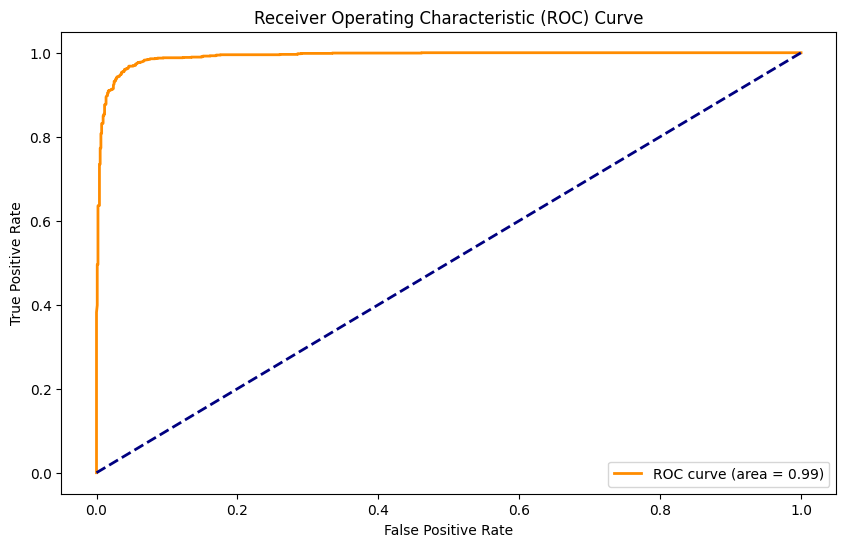

In [14]:
MetricFunctions.plotROCCurve(Y_test, y_score)

222/222 - 0s - 139ms/epoch - 626us/step


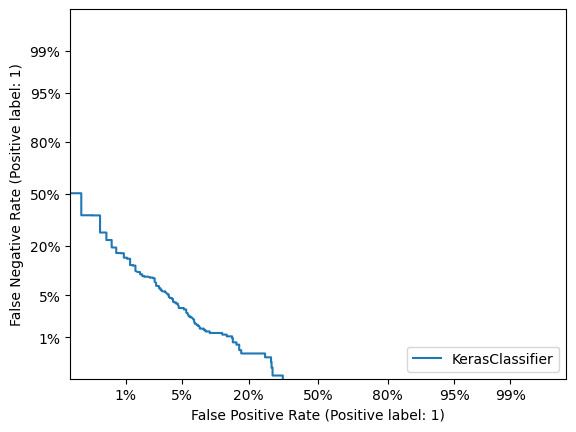

In [15]:
MetricFunctions.plotDetCurve(best_model, X_test, Y_test)

Confusion Matrix:
[[ 926   34]
 [  59 1192]]


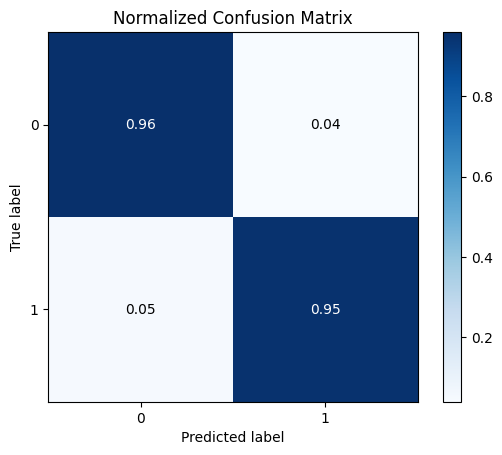

In [16]:
MetricFunctions.printConfMatrix(Y_test, y_pred)
MetricFunctions.plotConfMatrix(Y_test, y_pred)

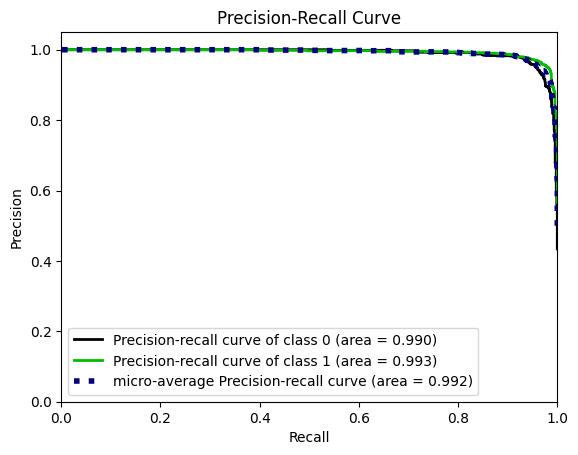

In [17]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_precision_recall(Y_test, y_prob)
plt.show()

In [18]:
import eli5
from eli5.sklearn import PermutationImportance

In [19]:
print(X.columns.tolist())

['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [20]:
perm = PermutationImportance(best_model, random_state=2023).fit(X_test,Y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

222/222 - 0s - 137ms/epoch - 617us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 134ms/epoch - 604us/step
222/222 - 0s - 134ms/epoch - 604us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 132ms/epoch - 595us/step
222/222 - 0s - 131ms/epoch - 590us/step
222/222 - 0s - 136ms/epoch - 613us/step
222/222 - 0s - 136ms/epoch - 613us/step
222/222 - 0s - 133ms/epoch - 599us/step
222/222 - 0s - 135ms/epoch - 608us/step
222/222 - 0s - 135ms/epoch - 608us/step
222/222 - 0s - 137ms/epoch - 617us/step
222/222 - 0s - 132ms/epoch - 595us/step
222/222 - 0s - 134ms/epoch - 604us/step
222/222 - 0s - 136ms/epoch - 613us/step
222/222 - 0s - 132ms/epoch - 595us/step
222/222 - 0s - 131ms/epoch - 590us/step
222/222 - 0s - 134ms/epoch - 604us/step
222/222 - 0s - 131ms/epoch - 590us/step
222/222 - 0s - 133ms/epoch - 599us/step


Weight,Feature
0.1348 ± 0.0111,URL_of_Anchor
0.0795 ± 0.0100,SSLfinal_State
0.0386 ± 0.0084,Prefix_Suffix
0.0274 ± 0.0051,web_traffic
0.0240 ± 0.0050,Links_in_tags
0.0232 ± 0.0031,having_Sub_Domain
0.0216 ± 0.0043,Links_pointing_to_page
0.0197 ± 0.0035,SFH
0.0179 ± 0.0050,Request_URL
0.0173 ± 0.0042,Domain_registeration_length


In [21]:
import pickle

model_pkl_file = "nn_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)